# Trabalho de análise de dados da matéria do professor Laio
-----
Aluno: Leonardo José
Tema: Análise de fuga de corrente devido a deposicao de sal em insuladores em alto mar
O presente trabalho utiliza a combinacao de arquiteturas Seq2Seq e LSTM fornecidas pelo professor, com a adicao de estrutura "atention" para auxiliar a rede a focar em elementos relevante sna hora do treinamento. O uso de rede Seq2Seq + LSTM se deve ao fato dos dados terem relacao temporal entre eles, com um input "rolante" de uma sequencia e um output de uma sequencia de dados que serao a previsao da corrente nos insuladores.

#### Obtencao dos dados:

In [23]:
import pandas as pd
import torch

# Arquivo .xlsx com as informações dos insuladores
file_path = 'BaseDados.xlsx'
# Colunas de insuladores
col_insulators = [9, 10, 11, 12, 13, 14]

# Dados dos 6 insuladores para teste
insulators_df = pd.read_excel(file_path, usecols=col_insulators)

# Converte em um dicionario de tensores
insulators_tensors = {}
for num_insulator in range(len(col_insulators)):
    insulator_column = insulators_df.iloc[:, num_insulator]
    insulator_numpy = insulator_column.to_numpy()
    insulator_tensor = torch.tensor(insulator_numpy)

    # Filtra os valores zero no final da sequência, pois é onde acaba a leitura da corrente no teste
    non_zero_indices = (insulator_tensor != 0).nonzero(as_tuple=True)[0]
    last_non_zero_index = non_zero_indices[-1].item()  # Obtém o valor como inteiro
    filtered_tensor = insulator_tensor[:last_non_zero_index + 1]

    insulators_tensors[f'insulator_{num_insulator + 1}'] = filtered_tensor
    print(f"Insulator {num_insulator + 1} tensor (filtrado):")
    print(filtered_tensor)





Insulator 1 tensor (filtrado):
tensor([0.0540, 0.0550, 0.0540,  ..., 0.2150, 0.2030, 1.0000],
       dtype=torch.float64)
Insulator 2 tensor (filtrado):
tensor([0.0490, 0.0500, 0.0500,  ..., 0.2270, 0.2270, 0.2260],
       dtype=torch.float64)
Insulator 3 tensor (filtrado):
tensor([0.0350, 0.0360, 0.0350,  ..., 0.2090, 0.2040, 0.2060],
       dtype=torch.float64)
Insulator 4 tensor (filtrado):
tensor([0.0350, 0.0350, 0.0350,  ..., 0.2470, 0.2310, 1.0000],
       dtype=torch.float64)
Insulator 5 tensor (filtrado):
tensor([0.0380, 0.0380, 0.0380,  ..., 0.3750, 0.4140, 1.0000],
       dtype=torch.float64)
Insulator 6 tensor (filtrado):
tensor([0.0350, 0.0350, 0.0350,  ..., 0.1980, 0.1990, 1.0000],
       dtype=torch.float64)


### Verificar a correlacao entre os insuladores

In [1]:
import pandas as pd
from phik import phik

# Suponha que temos dados de três insuladores em um DataFrame
data = {
    'Insulador1': [1.0, 2.0, 3.0, 4.0, 5.0],
    'Insulador2': [2.0, 3.5, 4.0, 5.0, 6.0],
    'Insulador3': [0.5, 1.5, 2.5, 3.5, 4.5],
}

df = pd.DataFrame(data)

# Calcular a matriz de correlação Phik
phik_matrix = df.phik_matrix()
print('Matriz de Correlação Phik:')
print(phik_matrix)


interval columns not set, guessing: ['Insulador1', 'Insulador2', 'Insulador3']
Matriz de Correlação Phik:
            Insulador1  Insulador2  Insulador3
Insulador1         1.0         1.0         1.0
Insulador2         1.0         1.0         1.0
Insulador3         1.0         1.0         1.0


### Filtragem dos dados:

### Rede neural do professor Seq2Seq + LSTM

Using device: cpu
Epoch [10/200], Loss: 0.4678
Epoch [20/200], Loss: 0.3740
Epoch [30/200], Loss: 0.2363
Epoch [40/200], Loss: 0.1929
Epoch [50/200], Loss: 0.0654
Epoch [60/200], Loss: 0.0450
Epoch [70/200], Loss: 0.0295
Epoch [80/200], Loss: 0.0158
Epoch [90/200], Loss: 0.0111
Epoch [100/200], Loss: 0.0035
Epoch [110/200], Loss: 0.0041
Epoch [120/200], Loss: 0.0027
Epoch [130/200], Loss: 0.0026
Epoch [140/200], Loss: 0.0017
Epoch [150/200], Loss: 0.0022
Epoch [160/200], Loss: 0.0012
Epoch [170/200], Loss: 0.0009
Epoch [180/200], Loss: 0.0012
Epoch [190/200], Loss: 0.0009
Epoch [200/200], Loss: 0.0007


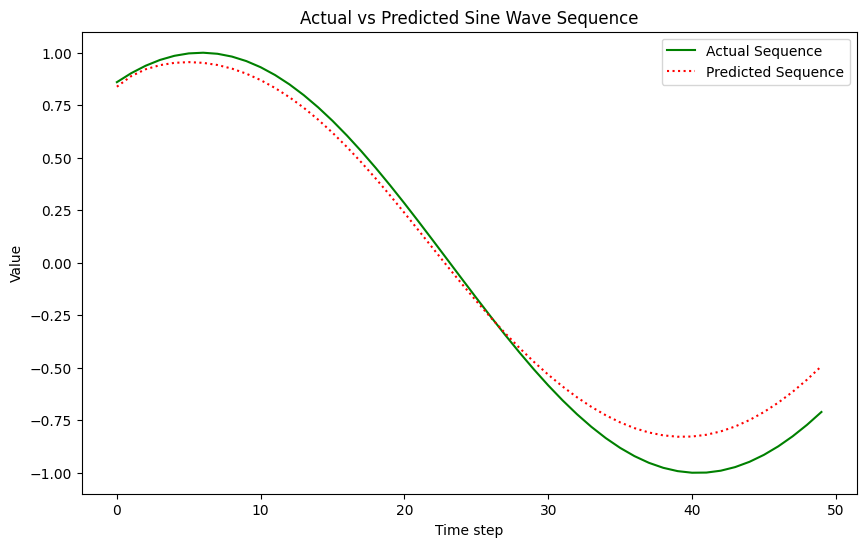

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        output, (hidden, cell) = self.lstm(input_seq)
        return hidden, cell

# Step 2: Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(output_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden, cell):
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))
        prediction = self.fc_out(output)
        return prediction, hidden, cell

# Step 3: Define the Seq2Seq model class with Teacher Forcing
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size = source_seq.shape[1]
        output_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(target_seq_len, batch_size, output_size).to(source_seq.device)

        hidden, cell = self.encoder(source_seq)

        decoder_input = torch.zeros(1, batch_size, output_size).to(source_seq.device)

        for t in range(target_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = output
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            decoder_input = output if not use_teacher_forcing else source_seq[t].unsqueeze(0)

        return outputs

# Step 4: Generate Sine Wave Data
def generate_sine_data(seq_len=50, n_samples=1000):
    X = np.linspace(0, 100, n_samples)
    y = np.sin(X)
    
    data = []
    for i in range(len(y) - seq_len):
        data.append(y[i:i+seq_len])

    data = np.array(data)
    data = data.reshape((data.shape[0], seq_len, 1))

    train_size = int(0.8 * data.shape[0])
    X_train = data[:train_size]
    X_test = data[train_size:]

    return torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)

# Step 5: Training the Seq2Seq model
def train_seq2seq(model, X_train, epochs=100, learning_rate=0.001, teacher_forcing_ratio=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(X_train.permute(1, 0, 2), X_train.shape[1], teacher_forcing_ratio)
        
        loss = criterion(outputs, X_train.permute(1, 0, 2))
        
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Step 6: Evaluation with plotting
def evaluate_seq2seq(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.permute(1, 0, 2), X_test.shape[1], teacher_forcing_ratio=0.0)
        predictions = predictions.permute(1, 0, 2).cpu().numpy()  # Convert to numpy for plotting
        X_test = X_test.cpu().numpy()  # Convert to numpy for plotting

        # Plot the actual and predicted sequences
        plt.figure(figsize=(10, 6))
        plt.plot(X_test[0], label="Actual Sequence", color='green')
        plt.plot(predictions[0], label="Predicted Sequence", linestyle=":", color='red')
        plt.title("Actual vs Predicted Sine Wave Sequence")
        plt.xlabel("Time step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

# Step 7: Putting it all together
if __name__ == "__main__":
    # Generate sine wave data
    X_train, X_test = generate_sine_data(seq_len=50, n_samples=1100)

    # Define the model parameters
    input_size = 1
    hidden_size = 64
    output_size = 1

    # Initialize Encoder, Decoder, and Seq2Seq model
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(hidden_size, output_size).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder).to(device)

    # Train the model
    train_seq2seq(seq2seq_model, X_train, epochs=200, learning_rate=0.001, teacher_forcing_ratio=0.5)

    # Evaluate and plot
    evaluate_seq2seq(seq2seq_model, X_test)